# <center>Author: Victor Diallen

# Table of Contents :
* [1. Introduction](#section1)
* [2. Importing Libraries](#section2)
* [3. Loading Datasets](#section3)
* [4. Exploratory Analysis](#section4)

<a id="section1"></a>
# Introduction

## Data Description

- Transport for London produces quarterly reports that provide analysis of incidents on the London bus network

## Notes

- In the exploratory analysis, both Python and SQL (using Spark) synthax were used

<a id="section2"></a>
# Importing Libraries

In [2]:
# Python version used
from platform import python_version
print('Python Version Used in this Jupyter Notebook:', python_version())

Python Version Used in this Jupyter Notebook: 3.9.7


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [4]:
# Libraries versions used in this jupyter notebook
%reload_ext watermark
%watermark -a "Victor Diallen" --iversions

Author: Victor Diallen

pyspark   : 3.3.2
findspark : 2.0.1
pandas    : 1.3.4
seaborn   : 0.11.2
numpy     : 1.21.4
matplotlib: 3.4.3



## Building Spark Environment

In [5]:
# Creating Spark Context
sc = SparkContext(appName = "Projeto3PythonSpark")

In [6]:
# Creating sessão
spark = SparkSession.builder.getOrCreate()

In [7]:
spark

<a id="section3"></a>
# Loading Dataset

In [8]:
# Loading dataset
df = pd.read_csv('TFL-Bus-Safety.csv')

In [9]:
df.head()

,Year,Date Of Incident,Route,Operator,Group Name,Bus Garage,Borough,Injury Result Description,Incident Event Type,Victim Category,Victims Sex,Victims Age
0,2015,1/1/2015,1,London General,Go-Ahead,Garage Not Available,Southwark,Injuries treated on scene,Onboard Injuries,Passenger,Male,Child
1,2015,1/1/2015,4,Metroline,Metroline,Garage Not Available,Islington,Injuries treated on scene,Onboard Injuries,Passenger,Male,Unknown
2,2015,1/1/2015,5,East London,Stagecoach,Garage Not Available,Havering,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
3,2015,1/1/2015,5,East London,Stagecoach,Garage Not Available,None London Borough,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
4,2015,1/1/2015,6,Metroline,Metroline,Garage Not Available,Westminster,Reported Minor Injury - Treated at Hospital,Onboard Injuries,Pedestrian,Female,Elderly


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23158 entries, 0 to 23157
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Year                       23158 non-null  int64 
 1   Date Of Incident           23158 non-null  object
 2   Route                      23158 non-null  object
 3   Operator                   23158 non-null  object
 4   Group Name                 23158 non-null  object
 5   Bus Garage                 23158 non-null  object
 6   Borough                    23158 non-null  object
 7   Injury Result Description  23158 non-null  object
 8   Incident Event Type        23158 non-null  object
 9   Victim Category            23158 non-null  object
 10  Victims Sex                23158 non-null  object
 11  Victims Age                23158 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.1+ MB


In [11]:
# Renaming columns
columns = ['Year', 'Date_of_Incident', 'Route', 'Operator', 'Group_Name', 'Bus_Garage', 'Borough',
          'Injury_Result_Description', 'Incident_Event_Type', 'Victim_Category', 'Victims_Sex', 'Victims_Age']
df.columns = columns

In [12]:
# Converting date column to date type in order to extract the month
df['Date_of_Incident'] = pd.to_datetime(df['Date_of_Incident'])

In [13]:
# Creating another column with month
df['Month'] = df['Date_of_Incident'].dt.strftime('%m')

In [14]:
# Creating another csv file (easier than editing Spark dataframes)
df.to_csv('TFL-Bus-Safety-Cols_Edited.csv', index=None)

In [15]:
df = pd.read_csv('TFL-Bus-Safety-Cols_Edited.csv')

In [16]:
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].astype(str)

In [17]:
df['Date_of_Incident'] = pd.to_datetime(df['Date_of_Incident'])

<a id="section4"></a>
# Exploratory Analysis

In [18]:
df.shape

(23158, 13)

In [19]:
# Checking for na values
df.isna().sum()

Year                         0
Date_of_Incident             0
Route                        0
Operator                     0
Group_Name                   0
Bus_Garage                   0
Borough                      0
Injury_Result_Description    0
Incident_Event_Type          0
Victim_Category              0
Victims_Sex                  0
Victims_Age                  0
Month                        0
dtype: int64

In [20]:
df.head(2)

,Year,Date_of_Incident,Route,Operator,Group_Name,Bus_Garage,Borough,Injury_Result_Description,Incident_Event_Type,Victim_Category,Victims_Sex,Victims_Age,Month
0,2015,2015-01-01,1,London General,Go-Ahead,Garage Not Available,Southwark,Injuries treated on scene,Onboard Injuries,Passenger,Male,Child,1
1,2015,2015-01-01,4,Metroline,Metroline,Garage Not Available,Islington,Injuries treated on scene,Onboard Injuries,Passenger,Male,Unknown,1


In [21]:
# Creating Spark dataframe to use SQL queries
df_sql = spark.read.csv('TFL-Bus-Safety-Cols_Edited.csv', header=True)

In [22]:
# Create Temporary View
df_sql.createOrReplaceTempView("tb")

## 1 - Incidents by Gender

In [23]:
# Data analysis using Python programming language
df['Victims_Sex'].value_counts()

Female     11847
Male        7709
Unknown     3602
Name: Victims_Sex, dtype: int64

In [24]:
# Data analysis using SQL queries
spark.sql("""
SELECT Victims_Sex, COUNT(*) AS Incidents_by_Sex
FROM tb
GROUP BY Victims_Sex
ORDER BY Incidents_by_Sex DESC
""").show()

+-----------+----------------+
|Victims_Sex|Incidents_by_Sex|
+-----------+----------------+
|     Female|           11847|
|       Male|            7709|
|    Unknown|            3602|
+-----------+----------------+



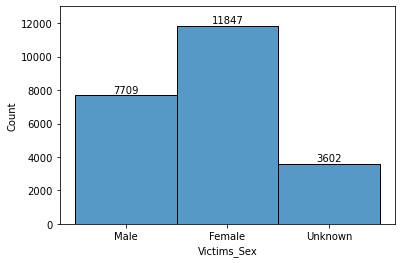

In [25]:
# Plotting
ax = sns.histplot(df['Victims_Sex']) 
ax.set_ylim(0,13000)
ax.bar_label(ax.containers[0]);

## 2 - Incidents by Age

In [26]:
# Data analysis using Python programming language
df['Victims_Age'].value_counts()

Adult      10754
Unknown     7135
Elderly     2769
Child       2181
Youth        319
Name: Victims_Age, dtype: int64

In [27]:
# Data analysis using SQL queries
spark.sql("""
SELECT Victims_Age, COUNT(*) AS Incidents_by_Age
FROM tb
GROUP BY Victims_Age
ORDER BY Incidents_by_Age DESC
""").show()

+-----------+----------------+
|Victims_Age|Incidents_by_Age|
+-----------+----------------+
|      Adult|           10754|
|    Unknown|            7135|
|    Elderly|            2769|
|      Child|            2181|
|      Youth|             319|
+-----------+----------------+



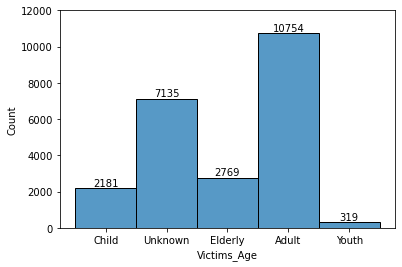

In [28]:
# Plotting
ax = sns.histplot(df['Victims_Age']) 
ax.set_ylim(0,12000)
ax.bar_label(ax.containers[0]);

## 3 - Incident Eventy Type Percentage

In [29]:
# Data analysis using Python programming language
incident_type_percentage = pd.DataFrame(df['Incident_Event_Type'].value_counts(normalize=True)*100).reset_index()
incident_type_percentage.columns = ['Event_Type', 'Total_Percentage']
incident_type_percentage

,Event_Type,Total_Percentage
0,Slip Trip Fall,30.145090
1,Onboard Injuries,28.340098
2,Personal Injury,19.846273
3,Collision Incident,17.989464
4,Assault,2.547716
5,Activity Incident Event,0.492270
6,Vandalism Hooliganism,0.315226
7,Safety Critical Failure,0.284999
8,Fire,0.025909
9,Robbery,0.012954


In [30]:
# Grouping event types with a percentage lower than 16 and naming it 'others'
others = incident_type_percentage[incident_type_percentage['Total_Percentage'] < 16].sum().values

In [31]:
incident_type_percentage.loc[len(incident_type_percentage)] = others

In [32]:
incident_type_percentage['Event_Type'][10] = 'Others'

C:\Users\Victor\AppData\Local\Temp/ipykernel_24304/1047508093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_type_percentage['Event_Type'][10] = 'Others'


In [33]:
incident_type_percentage = incident_type_percentage[incident_type_percentage['Total_Percentage'] > 3]

In [34]:
incident_type_percentage

,Event_Type,Total_Percentage
0,Slip Trip Fall,30.145090
1,Onboard Injuries,28.340098
2,Personal Injury,19.846273
3,Collision Incident,17.989464
10,Others,3.679074


In [35]:
# Data analysis using SQL queries
spark.sql("""
SELECT Incident_Event_Type, COUNT(*) as Total, ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS Percentage
FROM tb
GROUP BY Incident_Event_Type
ORDER BY Percentage DESC
""").show()

+--------------------+-----+----------+
| Incident_Event_Type|Total|Percentage|
+--------------------+-----+----------+
|      Slip Trip Fall| 6981|     30.15|
|    Onboard Injuries| 6563|     28.34|
|     Personal Injury| 4596|     19.85|
|  Collision Incident| 4166|     17.99|
|             Assault|  590|      2.55|
|Activity Incident...|  114|      0.49|
|Vandalism Hooliga...|   73|      0.32|
|Safety Critical F...|   66|      0.28|
|                Fire|    6|      0.03|
|             Robbery|    3|      0.01|
+--------------------+-----+----------+



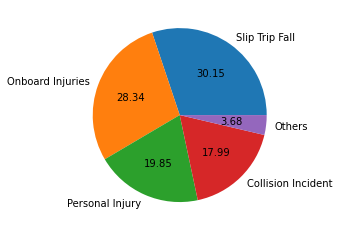

In [36]:
# Plotting
def absolute_value(val):
    a  = np.round(val/100.*np.sum(incident_type_percentage['Total_Percentage']), 2)
    return a

plt.pie(incident_type_percentage['Total_Percentage'].values, labels = incident_type_percentage['Event_Type'], autopct=absolute_value);

## 4 - Incidents by Month Throughout the Years

In [37]:
# Data analysis using Python programming language
incidents_evol_month = pd.DataFrame(df.groupby(['Year', 'Month'])['Incident_Event_Type'].count().reset_index(name='count'))
incidents_evol_month.columns = ['Year', 'Month', 'Total_Incidents']
incidents_evol_month['Month'] = incidents_evol_month['Month'].astype(int)
incidents_evol_month = incidents_evol_month.sort_values(by='Month')
incidents_evol_month

,Year,Month,Total_Incidents
0,2015,1,399
24,2017,1,435
12,2016,1,466
36,2018,1,547
4,2015,2,371
37,2018,2,507
16,2016,2,484
28,2017,2,487
29,2017,3,579
5,2015,3,460


In [38]:
# Data analysis using SQL queries
spark.sql("""
SELECT Year, Month, COUNT(*) AS Number_of_Incidents
FROM tb
GROUP BY Year, Month
ORDER BY Month ASC
""").show()

+----+-----+-------------------+
|Year|Month|Number_of_Incidents|
+----+-----+-------------------+
|2015|   01|                399|
|2016|   01|                466|
|2018|   01|                547|
|2017|   01|                435|
|2016|   02|                484|
|2018|   02|                507|
|2015|   02|                371|
|2017|   02|                487|
|2017|   03|                579|
|2015|   03|                460|
|2016|   03|                449|
|2018|   03|                535|
|2016|   04|                504|
|2017|   04|                563|
|2018|   04|                507|
|2015|   04|                470|
|2015|   05|                472|
|2017|   05|                510|
|2016|   05|                494|
|2018|   05|                589|
+----+-----+-------------------+
only showing top 20 rows



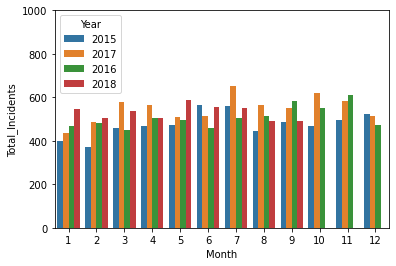

In [39]:
ax = sns.barplot(x = incidents_evol_month['Month'], y = incidents_evol_month['Total_Incidents'], hue=incidents_evol_month['Year'])
ax.set_ylim(0,1000);

## 5 - Female Incidents by Month when Collision Incident

In [40]:
# Data analysis using Python programming language
Fem_Col_Inc_Month = pd.DataFrame(df[(df['Incident_Event_Type'] == 'Collision Incident') & (df['Victims_Sex'] == 'Female')].groupby('Month')['Victims_Sex'].count()).reset_index()
Fem_Col_Inc_Month.columns = ['Month', 'Total_Incidents']
Fem_Col_Inc_Month

,Month,Total_Incidents
0,1,137
1,10,113
2,11,140
3,12,76
4,2,116
5,3,129
6,4,147
7,5,123
8,6,150
9,7,147


In [41]:
# Data analysis using SQL queries
spark.sql("""
SELECT Month, COUNT(*) AS Female_Collision_Incidents
FROM tb
WHERE Incident_Event_Type = 'Collision Incident' AND Victims_Sex = 'Female'
GROUP BY Month
ORDER BY Month ASC
""").show()

+-----+--------------------------+
|Month|Female_Collision_Incidents|
+-----+--------------------------+
|   01|                       137|
|   02|                       116|
|   03|                       129|
|   04|                       147|
|   05|                       123|
|   06|                       150|
|   07|                       147|
|   08|                       122|
|   09|                       158|
|   10|                       113|
|   11|                       140|
|   12|                        76|
+-----+--------------------------+



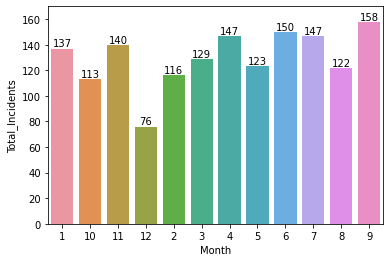

In [42]:
# Plotting
ax = sns.barplot(x = Fem_Col_Inc_Month['Month'], y = Fem_Col_Inc_Month['Total_Incidents'])
ax.set_ylim(0,170)
for i in ax.containers:
    ax.bar_label(i,)

## 6 - Incidents Monthly Mean Involving Children

In [43]:
# Data analysis using Python programming language
child_incidents_by_month = pd.DataFrame(df[df['Victims_Age'] == 'Child'].groupby('Month')['Victims_Age'].count()).reset_index()
child_incidents_by_month.columns = ['Month', 'Total_Incidents']
num_list = list(map(int, child_incidents_by_month['Total_Incidents']))
child_incidents_by_month_mean = [x/4 for x in num_list]
child_incidents_by_month_mean = [ '%.2f' % elem for elem in child_incidents_by_month_mean ]
child_incidents_by_month_mean
child_incidents_by_month['Mean'] = child_incidents_by_month_mean
child_incidents_by_month['Mean'] = child_incidents_by_month['Mean'].astype(float)
child_incidents_by_month['Month'] = child_incidents_by_month['Month'].astype(int)
child_incidents_by_month = child_incidents_by_month.sort_values(by='Month')
child_incidents_by_month

,Month,Total_Incidents,Mean
0,1,126,31.50
4,2,146,36.50
5,3,190,47.50
6,4,226,56.50
7,5,206,51.50
8,6,245,61.25
9,7,232,58.00
10,8,208,52.00
11,9,225,56.25
1,10,150,37.50


In [44]:
# Data analysis using SQL queries
spark.sql("""
SELECT Month, ROUND(COUNT(*)/4, 2) AS Incidents_Average_per_Month
FROM tb
WHERE Victims_Age = 'Child'
GROUP BY Month
ORDER BY Month
""").show()

+-----+---------------------------+
|Month|Incidents_Average_per_Month|
+-----+---------------------------+
|   01|                       31.5|
|   02|                       36.5|
|   03|                       47.5|
|   04|                       56.5|
|   05|                       51.5|
|   06|                      61.25|
|   07|                       58.0|
|   08|                       52.0|
|   09|                      56.25|
|   10|                       37.5|
|   11|                       30.0|
|   12|                      26.75|
+-----+---------------------------+



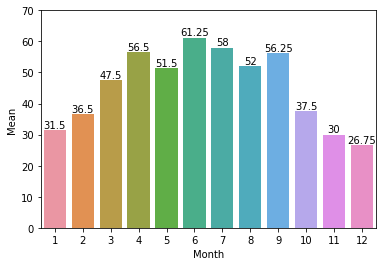

In [45]:
# Plotting
ax = sns.barplot(x = child_incidents_by_month['Month'], y = child_incidents_by_month['Mean'])
ax.set_ylim(0,70)
for i in ax.containers:
    ax.bar_label(i,)

## 7 - Injuries Treated on Scene by Sex

In [46]:
# Data analysis using Python programming language
inj_tre_sce_sex = pd.DataFrame(df[df['Injury_Result_Description'] == 'Injuries treated on scene'].groupby('Victims_Sex')['Injury_Result_Description'].count()).reset_index()
inj_tre_sce_sex.columns = ['Victims_Sex', 'Total_Incidents']
inj_tre_sce_sex

,Victims_Sex,Total_Incidents
0,Female,8816
1,Male,5632
2,Unknown,2888


In [47]:
# Data analysis using SQL queries
spark.sql("""
SELECT Victims_Sex, COUNT(*) AS Injuries_Treated_on_Scene_by_Sex
FROM tb
WHERE Injury_Result_Description = 'Injuries treated on scene'
GROUP BY Victims_Sex
""").show()

+-----------+--------------------------------+
|Victims_Sex|Injuries_Treated_on_Scene_by_Sex|
+-----------+--------------------------------+
|     Female|                            8816|
|    Unknown|                            2888|
|       Male|                            5632|
+-----------+--------------------------------+



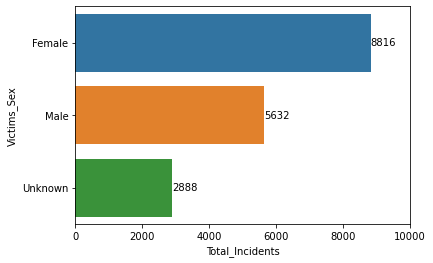

In [48]:
# Plotting
ax = sns.barplot(x = inj_tre_sce_sex['Total_Incidents'], y = inj_tre_sce_sex['Victims_Sex'])
ax.set_xlim(0,10000)
for i in ax.containers:
    ax.bar_label(i,)

## 8 - Elderly Incidents in 2017

In [49]:
# Data analysis using Python programming language
elderly_incidents = pd.DataFrame(df[(df['Year'] == '2017') & (df['Victims_Age'] == 'Elderly')].groupby('Month')['Victims_Age'].count()).reset_index()
elderly_incidents.columns = ['Month', 'Total_Incidents']
elderly_incidents['Month'] = elderly_incidents['Month'].astype(int)
elderly_incidents = elderly_incidents.sort_values(by='Month')
elderly_incidents

,Month,Total_Incidents
0,1,66
4,2,53
5,3,77
6,4,75
7,5,69
8,6,65
9,7,81
10,8,70
11,9,78
1,10,69


In [50]:
# Data analysis using SQL queries
spark.sql("""
SELECT Month, COUNT(*) AS Elderly_Incidents_in_2017
FROM tb
WHERE Year = '2017' AND Victims_Age = 'Elderly'
GROUP BY Month
ORDER BY Month ASC
""").show()

+-----+-------------------------+
|Month|Elderly_Incidents_in_2017|
+-----+-------------------------+
|   01|                       66|
|   02|                       53|
|   03|                       77|
|   04|                       75|
|   05|                       69|
|   06|                       65|
|   07|                       81|
|   08|                       70|
|   09|                       78|
|   10|                       69|
|   11|                       68|
|   12|                       67|
+-----+-------------------------+



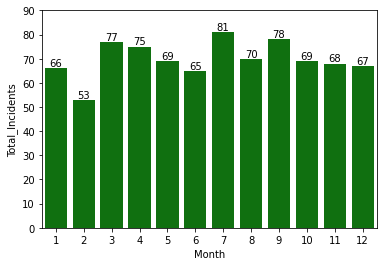

In [51]:
# Plotting
ax = sns.barplot(x = elderly_incidents['Month'], y = elderly_incidents['Total_Incidents'], color='green')
ax.set_ylim(0,90)
ax.bar_label(ax.containers[0]);

## 9 - Incidents by Operator over Time

In [52]:
# Data analysis using Python programming language
operator_incidents = pd.DataFrame(df.groupby(['Year','Operator'])['Incident_Event_Type'].agg('count').reset_index(name='Total_Incidents')).sort_values(by=['Total_Incidents', 'Year'], ascending=False)
operator_incidents

,Year,Operator,Total_Incidents
44,2017,Arriva London North,1026
57,2017,Metroline,940
16,2015,Metroline,914
36,2016,Metroline,864
29,2016,East London,812
...,...,...,...
51,2017,H R Richmond,13
61,2017,TGM GROUP,6
39,2016,Sullivan Buses,2
81,2018,Sullivan Bus & Coach,1


In [53]:
# Data analysis using SQL queries
spark.sql("""
SELECT Year, Operator, COUNT(*) AS Total_Incidents
FROM tb
GROUP BY Year, Operator
ORDER BY Total_Incidents DESC
""").show()

+----+-------------------+---------------+
|Year|           Operator|Total_Incidents|
+----+-------------------+---------------+
|2017|Arriva London North|           1026|
|2017|          Metroline|            940|
|2015|          Metroline|            914|
|2016|          Metroline|            864|
|2016|        East London|            812|
|2015|Arriva London North|            789|
|2018|          Metroline|            739|
|2018|Arriva London North|            737|
|2015|      London United|            705|
|2015|        East London|            681|
|2016|Arriva London North|            656|
|2017|        East London|            578|
|2016|      London United|            577|
|2017|            Selkent|            573|
|2017|      London United|            518|
|2016|            Selkent|            513|
|2016|     London General|            504|
|2015|Arriva London South|            482|
|2018|            Selkent|            476|
|2017|Arriva London South|            470|
+----+-----

## 10 - Cyclists Incidents

In [54]:
# Data analysis using Python programming language
cyclist_incidents = pd.DataFrame(df[df['Victim_Category'] == 'Cyclist'].groupby('Incident_Event_Type')['Victim_Category'].count()).reset_index()
cyclist_incidents.columns = ['Incident_Event_Type', 'Total_Incidents']
cyclist_incidents

,Incident_Event_Type,Total_Incidents
0,Collision Incident,256
1,Onboard Injuries,4
2,Personal Injury,8
3,Slip Trip Fall,7


In [55]:
# Data analysis using SQL queries
spark.sql("""
SELECT Incident_Event_Type, COUNT(*) AS Cyclists_Incidents
FROM tb
WHERE Victim_Category = 'Cyclist'
GROUP BY Incident_Event_Type
ORDER BY Cyclists_Incidents DESC
""").show()

+-------------------+------------------+
|Incident_Event_Type|Cyclists_Incidents|
+-------------------+------------------+
| Collision Incident|               256|
|    Personal Injury|                 8|
|     Slip Trip Fall|                 7|
|   Onboard Injuries|                 4|
+-------------------+------------------+



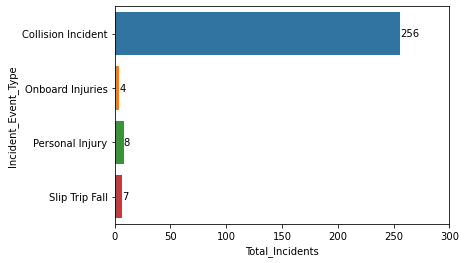

In [56]:
# Plotting
ax = sns.barplot(x = cyclist_incidents['Total_Incidents'], y = cyclist_incidents['Incident_Event_Type'])
ax.set_xlim(0,300)
for i in ax.containers:
    ax.bar_label(i,)